In [276]:
import pyreadstat
import pandas as pd
from imblearn.over_sampling import SMOTE

file_path = "ATP W89.sav"
df, meta = pyreadstat.read_sav(file_path)
# print(df.shape) # 164 columns

# initial filtering: drop clearly irrelevant
# keep columns with personal/demographic data, useful social media habits, target

df = df.drop(columns=["QKEY"])
interview_data = [x for x in df.columns if ("INTERVIEW" in x or "DEVICE" in x or "FORM" in x)] # asked ChatGPT for example subsetting list based on element values
df = df.drop(columns=interview_data)
# our target: how engaged individuals were
target = "ENGACTCT_W89"
# 2 features about social media habits selected from examining meaning in questionnaire/their metadata labels
sm_features = ["CLIMSEEK_W89","FOLCLIM_W89"]
# no longer need other questionnaire data, only using ENGACTCT to measure engagement, two social media habit cols relevant, personal data
personal_data = [x for x in df.columns if ("W89" not in x)]
keep_columns = personal_data + sm_features + [target]
df = df.loc[:,keep_columns]


def get_feat_vals_labels(column):
    print(df[column].value_counts())
    print(meta.variable_value_labels.get(column))

def get_na_columns():
    na_counts = pd.DataFrame({"na":df.isna().apply(sum)})
    na_columns = na_counts.loc[na_counts["na"]>0]
    return na_columns


# na_columns = get_na_columns()
# for col in na_columns.index:
#     get_feat_vals_labels(col)
df = df.drop(columns=["F_BORN","F_PARTYLN_FINAL"]) # dropped these columns b/c high proportion of NaNs & exist at least 1 other complete col describing similar data

# impute missing vals and 99.0s ('Refused') with mode
na_cols = get_na_columns().index
for i in range(len(df.columns)):
    column = df.columns[i]
    col_mode = df[column].mode()[0]
    if(column in na_cols):
        df[column] = df[column].fillna(col_mode)
    df[column] = df[column].apply(lambda x: col_mode if x==99.0 else x) # treat 99.0 ("Refused") as missing val
    # print(df[column].value_counts()) # verify no 99.0s remain

# Also want to recode the target feature -> target column name, values more interpretable:
df = df.rename(columns={"ENGACTCT_W89":"Engagement"})
df["Engagement"] = df["Engagement"].apply(lambda x: 1 if x>=2.0 else 0) # 1 represents active/engaged, 0 not

# Check for imbalances
print(df["Engagement"].value_counts()) # need to resample

# run SMOTE
smote = SMOTE(random_state=3001)
target = df["Engagement"]
feat_df = df.drop(columns=["Engagement"])
print(feat_df.shape,target.shape)
feat_df_balanced, target_balanced = smote.fit_resample(feat_df,target)
print(feat_df_balanced.shape,target_balanced.shape) # fix oversampling, then remember the recoding of target into >2, <=2

# Ready for PCA: missing vals addressed, all cols encoded, no need to scale b/c encoding addresses scale (e.g. income ranges instead of raw incomes), sampling done for imbalance

Engagement
0    12029
1     1720
Name: count, dtype: int64
(13749, 28) (13749,)
(24058, 28) (24058,)


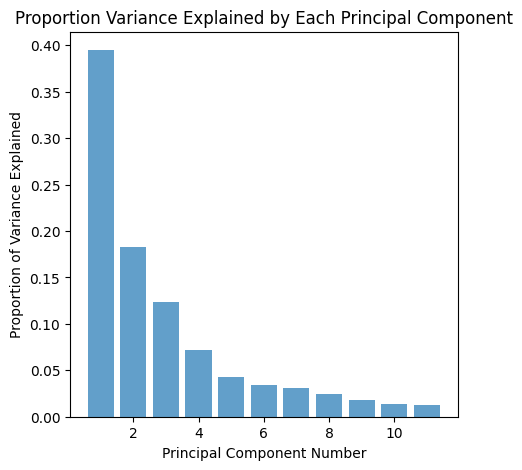

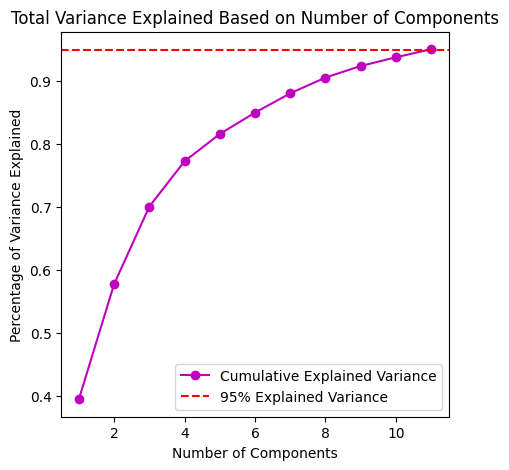

                      Cum_feature_weight
F_ATTEND                        2.128974
F_PARTYSUM_FINAL                1.903858
F_IDEO                          1.896234
F_BIRTHPLACE                    1.717073
F_RACECMB                       1.616310
F_EDUCCAT5                      1.613232
F_GENERATIONS                   1.606999
F_RACETHNMOD                    1.605481
F_PARTY_FINAL                   1.586361
F_RELIG                         1.554027
F_AGECAT                        1.515907
F_INC_SDT1                      1.500340
F_PARTYSUMIDEO_FINAL            1.464652
F_YEARSINUS                     1.443729
F_CDIVISION                     1.201681
F_EDUCCAT                       1.079838
F_INTFREQ                       0.684306
F_RELIGCAT1                     0.512004
F_CREGION                       0.494773
F_VOLSUM                        0.345851
F_HISP                          0.275616
F_REG                           0.273565
F_INC_TIER2                     0.273117
F_GENDER        

In [277]:
# PCA:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
def fit_pca(num_comp):
    pca = PCA(n_components=num_comp)
    pca.fit_transform(feat_df)
    return pca

def plot_pc_proportions(pca):
    pca_var_proportions = pca.explained_variance_ratio_
    plt.figure(figsize=[5,5])
    plt.bar(range(1,len(pca_var_proportions)+1),pca_var_proportions, alpha=0.7) #x-axis is PC #, y-axis is proportion of variance that PC explains
    plt.xlabel("Principal Component Number")
    plt.ylabel("Proportion of Variance Explained")
    plt.title("Proportion Variance Explained by Each Principal Component")
    return pca_var_proportions

def plot_cumulative_var(pca_var_proportions):
    cumulative_var = np.cumsum(pca_var_proportions) #each element is sum of any prev proportions + current
    plt.figure(figsize=[5,5])
    plt.plot(range(1,len(cumulative_var)+1),cumulative_var,marker='o',linestyle='-',color='m',label='Cumulative Explained Variance') # modeled after class pca notebook
    plt.xlabel("Number of Components")
    plt.ylabel("Percentage of Variance Explained")
    plt.title("Total Variance Explained Based on Number of Components")
    plt.axhline(y=0.95,color='r',linestyle='--',label="95% Explained Variance")
    plt.legend()
    plt.show()


pca = fit_pca(11) # adjustest arg until threshold reached: need 11 components to explain 95% variance
proportions = plot_pc_proportions(pca)
plot_cumulative_var(proportions)

initial_cum_weights = np.zeros(len(feat_df.columns)) # asked ChatGPT how to make a zero-initialized array
cum_weight_df = pd.DataFrame({"Cum_feature_weight":initial_cum_weights})
cum_weight_df.index = feat_df.columns

for i in range(0,11):
    pc = pca.components_[i]
    pc_df = pd.DataFrame({"Proportion of PC Calculation":pc})
    pc_df = pc_df.apply(abs)
    pc_df.index = feat_df.columns

    for column in feat_df.columns:
        rel_importance = pc_df.loc[column,"Proportion of PC Calculation"]
        cum_weight_df.loc[column,"Cum_feature_weight"] += rel_importance

cum_weight_df = cum_weight_df.sort_values(by="Cum_feature_weight",ascending=False)
print(cum_weight_df)
